Import modules


In [71]:
import numpy as np
import matplotlib.pyplot as plt
from netCDF4 import Dataset
import matplotlib
from matplotlib.ticker import MaxNLocator,FormatStrFormatter
import pickle
from glob import glob
import sys  
import matplotlib.gridspec as gridspec
from scipy.stats import linregress
from dateutil.relativedelta import relativedelta
import itertools
import pickle
import cartopy
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER



from scipy.ndimage import label,find_objects
import scipy.ndimage as ndimage
from matplotlib.colors import LinearSegmentedColormap

import datetime as dt
### Hack to import basemap ###
import os
import conda

# conda_file_dir = conda.__file__
# conda_dir = conda_file_dir.split('lib')[0]
# proj_lib = os.path.join(os.path.join(conda_dir, 'share'), 'proj')
# os.environ["PROJ_LIB"] = proj_lib

# from mpl_toolkits import basemap


%matplotlib inline

TRMM stands for tropical rainfall measuring mission: <a href="https://gpm.nasa.gov/trmm">https://gpm.nasa.gov/trmm</a>. TRMM 3B42 product is a multi-satellite product with rainfall available at 3 hourly intervals.  The product contains data at a horizontal resolution of 0.25$^\circ$ x 0.25$^\circ$ (latitutde x longitude) for all longitudes (0-360), and the near-equatorial longitudes (35$^\circ$ N - 35 $^\circ$ S). For our purposes, we use a subset of the TRMM 3B42 product:
<ul>
    <li> at <b>6 hourly</b> intervals, so four measurements per day.</li>
    <li> from (25$^\circ$ N - 25 $^\circ$ S), to avoid some mid-latitude clusters, but this extent can be adjusted
 </ul>

The algorithm in this notebook is roughly as follows:
<ol>
    <li> Create a list of TRMM files to read with specified start and end dates. Each file contains one month of data. </li>
    <li> Visualize the precipitation field, and the corresponding clusters for a specific time step. You can play around with this to develop a physical intuition for clusters </li>
    <li> Create clusters and construct probability density functions (pdfs) for cluster size and cluster power. The data can be saved to file to avoid re-running time consuming computation. </li>
    <li> Plot the pdfs for different time periods. You can play around to see how the pdfs vary with time length and period. Also include information about the cutoff in the plots. </li>
</ol>


### 1. Create a list of TRMM files to read with specified start and end dates. <br> Each file contains one month of data.


In [7]:
### Read TRMM files ###
### note that each file is monthly, so changing the day has no impact.
strt_date=dt.datetime(2008,1,1)  
# strt_date=dt.datetime(2002,1,1)  
end_date=dt.datetime(2014,12,1)
start_date=strt_date  ## store strt_date for future handling


diri='/scratch/neelin/TRMM_3B42/'
fili='TRMM.3B42.'

list1=[]
dts_trmm=[]

while strt_date<=end_date:
    d1=strt_date.strftime("%Y%m")
    dts_trmm.append(strt_date)
    fname=diri+fili+d1+'*'
    list_temp=(glob(fname))
    list_temp.sort()
    list1.append(list_temp)
    strt_date+=relativedelta(months=1)
    
chain1=itertools.chain.from_iterable(list1)
list_trmm= (list(chain1))

In [8]:
print(list_trmm[0],list_trmm[-1]) ## Check the first and last file to ensure that they match the dates

/scratch/neelin/TRMM_3B42/TRMM.3B42.200801.v7.nc /scratch/neelin/TRMM_3B42/TRMM.3B42.201412.v7.nc


### 2. Visualize the precipitation field, and the corresponding clusters for a specific time step.

In [142]:
### Create colorbar for precipitation ###

nws_precip_colors = [
#     "#04e9e7",  # 0.01 - 0.10 inches
#     "#019ff4",  # 0.10 - 0.25 inches
#     "#0300f4",  # 0.25 - 0.50 inches
    "#02fd02",  # 0.50 - 0.75 inches
    "#01c501",  # 0.75 - 1.00 inches
    "#008e00",  # 1.00 - 1.50 inches
    "#fdf802",  # 1.50 - 2.00 inches
    "#e5bc00",  # 2.00 - 2.50 inches
    "#fd9500",  # 2.50 - 3.00 inches
    "#fd0000",  # 3.00 - 4.00 inches
    "#d40000",  # 4.00 - 5.00 inches
    "#bc0000",  # 5.00 - 6.00 inches
#     "#f800fd",  # 6.00 - 8.00 inches
#     "#9854c6",  # 8.00 - 10.00 inches
#     "#fdfdfd"   # 10.00+
]
precip_colormap = matplotlib.colors.ListedColormap(nws_precip_colors)

levels=np.arange(0.0,5.25,.25)
norm = matplotlib.colors.BoundaryNorm(levels, precip_colormap.N)



In [11]:
# %%timeit
### Pick random file to visualize ###

fil_indx=80 ### change this index to pick a different month. Must be less than len(list_trmm).

f=Dataset(list_trmm[fil_indx],'r')
time=f.variables['time'][:]
prc=f.variables['precip_trmm'][:] ## Read precip (in mm/hr)
lat=f.variables['latitude'][:]
lon=f.variables['longitude'][:]
f.close()

### set precip. threshold here ###
prc_min_thresh=0.1
### set latitude and longtiude bounds here
ind_lon=np.where(np.logical_and(lon>0,lon<360))[0]
# ind_lat=np.where(abs(lat)<25)[0] ### 25 N - 25 S  
# lat=lat[ind_lat]

### take precip subset 
# ix=np.ix_(np.arange(prc.shape[0]),ind_lat,ind_lon)
### overwriting precip. with precip. subset
# prc=prc[ix]
### mask precip
prc_masked=np.ma.masked_where(prc<=prc_min_thresh,prc)

Pick a specific time step. Each month contains <i>number of days $\times$ 4 </i> timesteps. Visualize the precipitation map, and the clusters that can be formed out this map. Change time step to get a feel for how the clusters are produced.
<p>
    Right now, the code only produces the map for the entire TRMM domain. If you want to visualize a smaller domain, changing the plotting parameters below. </p>

In [36]:
[lon[0],lon[-1],lat[0],lat[-1]]

[0.125, 359.875, -34.875, 34.875]

In [113]:
Rearth=6.37e6  ## Earth's equatorial radius in meters

## get the grid sizes dx and dy in meters ###
nx =lon.size # no. of grid points
ny =lat.size  
dx=2.*np.pi*Rearth*(np.cos(np.pi*lat/180))/nx           #whole globe, periodic in x, dx in meters
dphi=np.gradient(lat)*np.pi/180  ## dphi in radians
dy=dphi*Rearth ## dy in meters

## for simplicity, we assume a single dx and dy for the domain. 
## Even though we should recognize that dx and dy vary with latitude.
precip_cluster_power_scale=2.5*dx.mean()*dy[0]*1e-6/3.6 ## cluster power in GW  ## Convert integrated precip. into power



prc_input=np.copy(prc_masked[timestep,:,:])
prc_input[prc_input<prc_min_thresh]=0.0
### Use pixel contiguity to identify clusters ##
labeled_prc, num_features = label(prc_input)
levels_labels=np.arange(0,num_features,1)
labels_masked=np.ma.masked_where(labeled_prc==0,labeled_prc)
cluster_power_masked=np.zeros_like(labels_masked)

pal=plt.get_cmap('YlGnBu')


label_objs=find_objects(labels_masked)
prc_input[label_objs[11]].sum()
print(len(label_objs))

for j in np.arange(len(label_objs)):

    sl=label_objs[j]
    pcp_slice=prc_input[sl]
    label_slice=labels_masked[sl]
    cluster_power_masked[sl][pcp_slice>0]=pcp_slice.sum()*precip_cluster_power_scale


1588


In [ ]:
levels_pow=np.arange(2.0,7.25,.25)
norm_pow = matplotlib.colors.BoundaryNorm(levels_pow, precip_colormap.N)

/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:60: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:110: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations


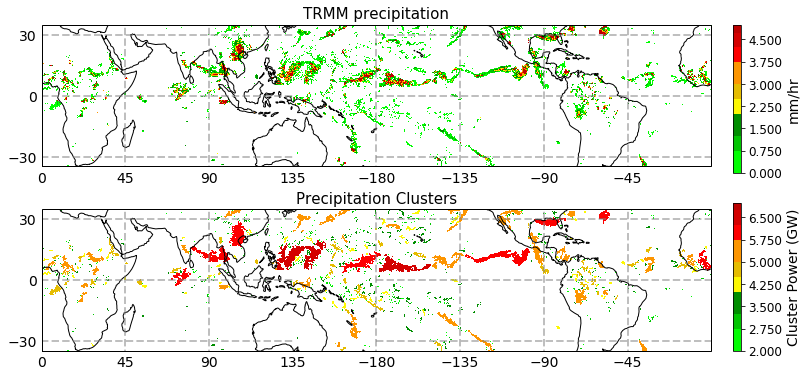

In [123]:
timestep=63


### Create subplots ###
fig,axx = plt.subplots(2,1,figsize=(12, 6),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

ax=axx[0]
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180),figsize=(12,6))
ax.coastlines()
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(prc_masked[timestep,:,:], 
             cmap=precip_colormap,
             interpolation='none',norm=norm, 
             extent=[lon[0],lon[-1],lat[0],lat[-1]],
             origin='lower', 
             transform=ccrs.PlateCarree())


# CT=ax.contourf(lon, lat, dilute.pcp,levels=levels_prc*0.2,cmap=cmap,extend='max', transform=ccrs.PlateCarree(),)
#get size and extent of axes:
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='mm/hr',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('TRMM precipitation',fontsize=15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}


ax=axx[1]
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180),figsize=(12,6))
ax.coastlines()
ax.set_extent([lon[0],lon[-1],lat[0],lat[-1]], crs=ccrs.PlateCarree())
CT=ax.imshow(np.log10(cluster_power_masked),cmap=precip_colormap,interpolation='none',aspect='auto',
             origin='lower',norm=norm_pow,
             extent=[lon[0],lon[-1],lat[0],lat[-1]],
             transform=ccrs.PlateCarree())


# CT=ax.contourf(lon, lat, dilute.pcp,levels=levels_prc*0.2,cmap=cmap,extend='max', transform=ccrs.PlateCarree(),)
#get size and extent of axes:
ax.set_aspect('auto')

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

ax.set_title('Precipitation Clusters',fontsize=15)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=2, color='gray', alpha=0.5, linestyle='--')
gl.xlabels_top = False
gl.ylabels_right = False

gl.xlines = True
gl.ylocator = mticker.FixedLocator(np.arange(-90,90,30))
gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
gl.xlabel_style = {'size': 14}
gl.ylabel_style = {'size': 14}


axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='Cluster Power (GW)',format='%.3f')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=12.)

axpos = ax.get_position()
pos_x = axpos.x0+axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0
cax_width = 0.01
cax_height = axpos.height

plt.subplots_adjust(left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.3)
plt.tight_layout()


Plot ERA-5

In [425]:
### Create colorbar for precipitation ###

discrete_colors = [
    "#C889FF",  # 0.50 - 0.75 inches
    "#30FFC1",  # 0.75 - 1.00 inches
    "#FFD6FF",  # 1.00 - 1.50 inches
    "#A5D6FF",  # 1.50 - 2.00 inches
    "yellow",  # 2.00 - 2.50 inches
#     "#fd9500",  # 2.50 - 3.00 inches
#     "#fd0000",  # 3.00 - 4.00 inches
#     "#d40000",  # 4.00 - 5.00 inches
#     "#bc0000",  # 5.00 - 6.00 inches
#     "#f800fd",  # 6.00 - 8.00 inches
#     "#9854c6",  # 8.00 - 10.00 inches
#     "#fdfdfd"   # 10.00+
]
discrete_colormap = matplotlib.colors.ListedColormap(discrete_colors)




In [426]:
cmap_jet=plt.get_cmap('gnuplot')
levels=np.arange(-.425,0.125,0.025)
norm_jet = matplotlib.colors.BoundaryNorm(levels, cmap_jet.N)

cmap_cluster=plt.get_cmap('Set1')
levels_pow=np.arange(2.0,7.25,2.25)
levels_pow=np.array((2.0,4.0,5.5,6.0,6.25,6.5))
norm_pow = matplotlib.colors.BoundaryNorm(levels_pow, discrete_colormap.N)

In [427]:
norm_pow

/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:26: RuntimeWarning: divide by zero encountered in log10


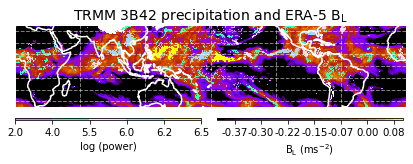

In [431]:
timestep=63
extent=[lon[0],lon[-1],lat[0],lat[-1]]
# extent=[120,260,lat[0],lat[-1]]

proj = ccrs.PlateCarree()

fig,axx = plt.subplots(1,1,figsize=(7, 1.5),subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

ax=axx
# ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=180),figsize=(12,6))
ax.set_extent(extent, crs=ccrs.PlateCarree())
CT1=ax.imshow(buoy_matched,cmap=cmap_jet,
             interpolation='none',
             norm=norm_jet,
             extent=extent,
             origin='lower',
             transform=ccrs.PlateCarree())

# CT=ax.imshow(prc_masked[timestep,:,:], 
#              cmap=precip_colormap,
#              interpolation='none',norm=norm, 
#              extent=[lon[0],lon[-1],lat[0],lat[-1]],
#              origin='lower', 
#              transform=ccrs.PlateCarree())

CT=ax.imshow(np.log10(cluster_power_masked),cmap=discrete_colormap,interpolation='none',
             origin='lower',norm=norm_pow,
             extent=extent,
             transform=ccrs.PlateCarree())


ax.coastlines(color='white',linewidth=1.5)



ax.outline_patch.set_edgecolor('white')


ax.set_aspect('auto')






# #get size and extent of axes:

axpos = ax.get_position()
pos_x = axpos.x0#axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0-0.125
cax_width = axpos.width/2.1
cax_height = 0.025
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT, cax=pos_cax,label='log (power)',format='%.1f',orientation='horizontal')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=10.25)


axpos = ax.get_position()
pos_x = axpos.x0+0.4#axpos.width + 0.025# + 0.25*axpos.width
pos_y = axpos.y0-0.125
cax_width = axpos.width/2.1
cax_height = 0.025
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
# plt.colorbar(CT, cax=pos_cax,label='GW',format='%.2f',orientation='horizontal')
# font = matplotlib.font_manager.FontProperties(family='Arial',  size=14)
# pos_cax.yaxis.label.set_font_properties(font)
# pos_cax.tick_params(which='both',labelsize=12.)


# axpos = ax.get_position()
# pos_x = axpos.x0+axpos.width*(1.05)
# pos_y = axpos.y0
# cax_width = 0.01
# cax_height = axpos.height
#create new axes where the colorbar should go.
#it should be next to the original axes and have the same height!
# pos_cax = fig.add_axes([pos_x,pos_y,cax_width,cax_height])
plt.colorbar(CT1, cax=pos_cax,label='$\mathrm{B_L}$ ($\mathrm{ms^{-2}}$)',format='%.2f',orientation='horizontal')
font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
pos_cax.yaxis.label.set_font_properties(font)
pos_cax.tick_params(which='both',labelsize=10.25)

# gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
#                   linewidth=2, color='white', alpha=1.0, linestyle='--')
ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=False,
                  linewidth=1, color='white', alpha=.5, linestyle='--')

ax.set_title('TRMM 3B42 precipitation and ERA-5 $\mathrm{B_L}$', fontsize=14)

# gl.xlabels_top = True
# gl.ylabels_right = False
# gl.xlabels_bottom = False


# gl.xlines = False
# gl.ylocator = mticker.FixedLocator(np.arange(-35,35,25))
# # gl.xlocator = mticker.FixedLocator(np.arange(-180,180,45))
# gl.xlabel_style = {'size': 14}
# gl.ylabel_style = {'size': 14}



plt.savefig('./TRMM3B42_ERA-5_BL_map_new.pdf',format='pdf',dpi=125,bbox_inches='tight')









Read MERRA-2 $\theta_e$ variables. An error in the code accidently wrote `MERRA-2` variables over `era_5` containers

In [124]:
match_time=dt.datetime.strptime(list_trmm[80][-12:-6],'%Y%m')+relativedelta(hours=63*6)

f=Dataset('./files/era5_merra2_2layers_thetae_2014_09_16.nc','r')
print(f)
lat_merra=f.variables['lat'][:]
lon_merra=f.variables['lon'][:]
thetae_bl_merra=f.variables['thetae_bl_era5'][:]
thetae_lt_merra=f.variables['thetae_lt_era5'][:]
thetae_sat_lt_merra2=f.variables['thetae_sat_lt_era5'][:]
f.close()
wts={}
wts['bl']=0.4
wts['lt']=0.6

buoy_an18=wts['bl']*thetae_bl_merra/thetae_sat_lt_merra2+\
wts['lt']*thetae_lt_merra/thetae_sat_lt_merra2

buoy_an18=9.80665*(buoy_an18-1)
buoy_an18[np.isinf(buoy_an18)]=np.nan

buoy_matched=buoy_an18[-2,:,:]
match_time

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8), lat(121), lon(576)
    variables(dimensions): int32 time(time), float32 lat(lat), float32 lon(lon), float32 thetae_bl_era5(time,lat,lon), float32 thetae_lt_era5(time,lat,lon), float32 thetae_sat_lt_era5(time,lat,lon), float32 thetae_bl_merra2(time,lat,lon), float32 thetae_lt_merra2(time,lat,lon), float32 thetae_sat_lt_merra2(time,lat,lon)
    groups: 


datetime.datetime(2014, 9, 16, 18, 0)

Plot ERA-5 data

In [125]:
f=Dataset('./files/era5_2layers_thetae_2014_09_16.nc','r')
print(f)
lat_era5=f.variables['lat'][:]
lon_era5=f.variables['lon'][:]
thetae_bl_era5=f.variables['thetae_bl'][:]
thetae_lt_era5=f.variables['thetae_lt'][:]
thetae_sat_lt_era52=f.variables['thetae_sat_lt'][:]
f.close()
wts={}
wts['bl']=0.4
wts['lt']=0.6

buoy_an18_era5=wts['bl']*thetae_bl_era5/thetae_sat_lt_era52+\
wts['lt']*thetae_lt_era5/thetae_sat_lt_era52

print(prc_masked.shape,buoy_an18_era5.shape)

buoy_an18_era5=9.80665*(buoy_an18_era5-1)
buoy_an18_era5[np.isinf(buoy_an18_era5)]=np.nan

buoy_matched=buoy_an18_era5[-2,:,:]
match_time

<class 'netCDF4._netCDF4.Dataset'>
root group (NETCDF4 data model, file format HDF5):
    dimensions(sizes): time(8), lat(280), lon(1440)
    variables(dimensions): int32 time(time), float32 lat(lat), float32 lon(lon), float32 thetae_bl(time,lat,lon), float32 thetae_lt(time,lat,lon), float32 thetae_sat_lt(time,lat,lon), float32 thetae_mt(time,lat,lon), float32 thetae_sat_mt(time,lat,lon)
    groups: 
(120, 280, 1440) (8, 280, 1440)


datetime.datetime(2014, 9, 16, 18, 0)

In [126]:
lat[40]
lat[-41]

24.875

NameError: name 'basemap' is not defined

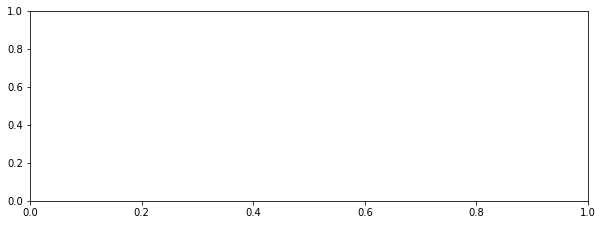

In [127]:
timestep=63

fig,axx=plt.subplots(1,1,figsize=(10,3.5))

ax=axx
m = basemap.Basemap(projection='merc', llcrnrlon=lon[500], urcrnrlon=lon[-280], llcrnrlat=lat[40], urcrnrlat=lat[-41], resolution='c',ax=ax)
m.drawcoastlines()

CT1=m.imshow(buoy_matched[40:-41,500:-280],cmap=cmap_jet,interpolation='none',norm=norm_jet, aspect='auto',origin='lower')
CT=m.imshow(prc_masked[timestep,40:-41,500:-280],cmap=precip_colormap,interpolation='none',norm=norm,aspect='auto',origin='lower')



ax.set_title('TRMM 3B42 precipitation and ERA-5 $\mathrm{B_L}$', fontsize=16)

ax.tick_params(which='both',labelsize=16.0)
ax.set_ylabel('latitude',fontsize=15)
ax.set_xlabel('longitude',fontsize=15)


cbaxes = fig.add_axes([ .95,.25, 0.01, 0.55]) 
cbar=plt.colorbar(CT,cax=cbaxes,label='mm/hr',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)



prc_input=np.copy(prc_masked[timestep,:,:])
prc_input[prc_input<prc_min_thresh]=0.0
### Use pixel contiguity to identify clusters ##
labeled_prc, num_features = label(prc_input)
levels_labels=np.arange(0,num_features,1)
labels_masked=np.ma.masked_where(labeled_prc==0,labeled_prc)
pal=plt.get_cmap('tab20c')


cbaxes = fig.add_axes([ 1.1,.25, 0.01, 0.55]) 
cbar=plt.colorbar(CT1,cax=cbaxes,label='$\mathrm{ms}^{-2}$',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)

# plt.savefig('./TRMM3B42_ERA-5_BL_map.pdf',format='pdf',dpi=125,bbox_inches='tight')








Plot MERRA-2 buoyancy

In [378]:
cmap_jet=plt.get_cmap('gnuplot')
levels=np.arange(-.425,0.125,0.025)
norm_jet = matplotlib.colors.BoundaryNorm(levels, cmap_jet.N)


In [379]:
f=Dataset("./files/TRMM.3B42.regridded.201409.nc",'r')
precip_regridded=f.variables['precip_trmm'][:]
f.close()
precip_regridded_masked=np.ma.masked_where(precip_regridded<=prc_min_thresh,precip_regridded)

lon_merra_flip=np.copy(lon_merra)
lon_merra_flip[lon_merra_flip<0]+=360
buoy_matched_flipped=buoy_matched[:,np.argsort(lon_merra_flip)]
precip_regridded_flipped=precip_regridded_masked[:,:,np.argsort(lon_merra_flip)]
lon_merra_flip=lon_merra_flip[np.argsort(lon_merra_flip)]

In [380]:
np.argmin(abs(lon_merra_flip-lon[500])),np.argmin(abs(lon_merra_flip-lon[-280]))
np.argmin(abs(lat_merra-lat[0])),np.argmin(abs(lat_merra-lat[-1]))

# lat[0],lat[-1]
# lat_merra[10],lat_merra[100]




(0, 120)

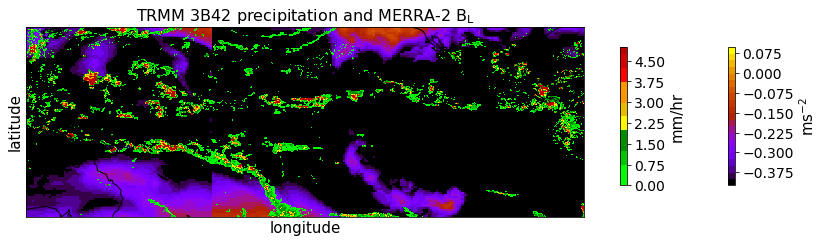

In [381]:
timestep=63

fig,axx=plt.subplots(1,1,figsize=(10,3.5))

ax=axx
m = basemap.Basemap(projection='merc', llcrnrlon=lon[500], urcrnrlon=lon[-280], llcrnrlat=lat[0], urcrnrlat=lat[-1], resolution='c',ax=ax)
m.drawcoastlines()

CT1=m.imshow(buoy_matched_flipped[10:110,199:463],cmap=cmap_jet,interpolation='none',norm=norm_jet, aspect='auto',origin='lower')
CT=m.imshow(prc_masked[timestep,:,500:-280],cmap=precip_colormap,interpolation='none',norm=norm,aspect='auto',origin='lower')



ax.set_title('TRMM 3B42 precipitation and MERRA-2 $\mathrm{B_L}$', fontsize=16)

ax.tick_params(which='both',labelsize=16.0)
ax.set_ylabel('latitude',fontsize=15)
ax.set_xlabel('longitude',fontsize=15)


cbaxes = fig.add_axes([ .95,.25, 0.01, 0.55]) 
cbar=plt.colorbar(CT,cax=cbaxes,label='mm/hr',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)



prc_input=np.copy(prc_masked[timestep,:,:])
prc_input[prc_input<prc_min_thresh]=0.0
### Use pixel contiguity to identify clusters ##
labeled_prc, num_features = label(prc_input)
levels_labels=np.arange(0,num_features,1)
labels_masked=np.ma.masked_where(labeled_prc==0,labeled_prc)
pal=plt.get_cmap('tab20c')


cbaxes = fig.add_axes([ 1.1,.25, 0.01, 0.55]) 
cbar=plt.colorbar(CT1,cax=cbaxes,label='$\mathrm{ms}^{-2}$',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)

# plt.savefig('./TRMM3B42_BL_map.pdf',format='pdf',dpi=125,bbox_inches='tight')







Try plotting with regridded TRMM data

In [382]:
desired_lons=np.arange(125,265,5)
xtick_ind=np.zeros_like(desired_lons)
xtick_labels=np.zeros_like(desired_lons)

for i,j in enumerate((desired_lons)):
    indx=(np.argmin(abs(j-lon_merra_flip[200:-150])))
    xtick_ind[i]=indx
    xtick_labels[i]=j


xtick_ind


array([  0,   7,  15,  23,  31,  39,  47,  55,  63,  71,  79,  87,  95,
       103, 111, 119, 127, 135, 143, 151, 159, 167, 175, 183, 191, 199,
       207, 215])

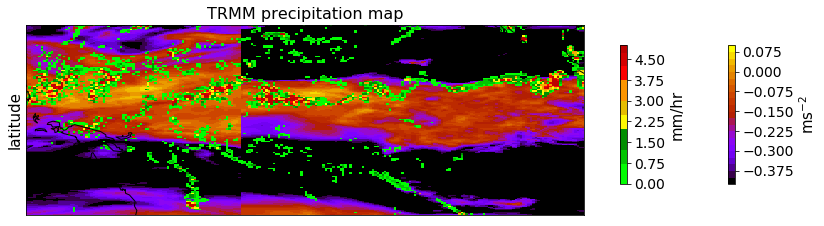

In [383]:
timestep=63

fig,axx=plt.subplots(1,1,figsize=(10,3.5))

ax=axx
m = basemap.Basemap(projection='merc', llcrnrlon=lon_merra_flip[200], urcrnrlon=lon_merra_flip[-150], llcrnrlat=lat_merra[0], urcrnrlat=lat_merra[-1], resolution='c',ax=ax)
m.drawcoastlines()

CT1=m.imshow(buoy_matched_flipped[:,200:-150],cmap=cmap_jet,interpolation='none',norm=norm_jet, aspect='auto',origin='lower')
CT=m.imshow(precip_regridded_flipped[timestep,:,200:-150],cmap=precip_colormap,interpolation='none',norm=norm,aspect='auto',origin='lower')
# ax.set_xticks(lon_merra_flip[200:-150][::100])
# ax.set_xticks([0,1000])
# ax.set_xticklabels(lon_merra_flip[200:-150][::100])



ax.set_title('TRMM precipitation map', fontsize=16)

ax.tick_params(which='both',labelsize=16.0)
ax.set_ylabel('latitude',fontsize=15)

cbaxes = fig.add_axes([ .95,.25, 0.01, 0.55]) 
cbar=plt.colorbar(CT,cax=cbaxes,label='mm/hr',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)

cbaxes = fig.add_axes([ 1.1,.25, 0.01, 0.55]) 
cbar=plt.colorbar(CT1,cax=cbaxes,label='$\mathrm{ms}^{-2}$',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)





In [384]:
ax.get_xticks()

array([], dtype=float64)

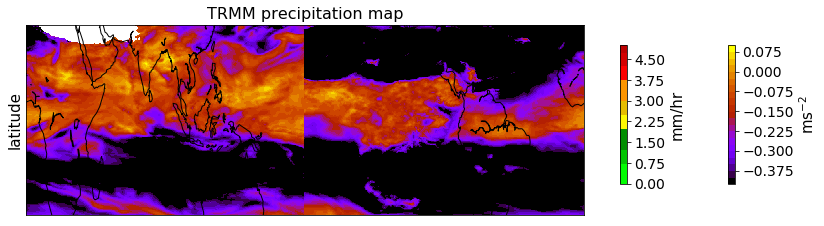

In [385]:
timestep=63

fig,axx=plt.subplots(1,1,figsize=(10,3.5))

ax=axx
m = basemap.Basemap(projection='merc', llcrnrlon=lon_merra_flip[0], urcrnrlon=lon_merra_flip[-1], llcrnrlat=lat_merra[0], urcrnrlat=lat_merra[-1], resolution='c',ax=ax)
m.drawcoastlines()

CT1=m.imshow(buoy_matched_flipped[:,:],cmap=cmap_jet,interpolation='none',norm=norm_jet, aspect='auto',origin='lower')



ax.set_title('TRMM precipitation map', fontsize=16)

ax.tick_params(which='both',labelsize=16.0)
ax.set_ylabel('latitude',fontsize=15)

cbaxes = fig.add_axes([ .95,.25, 0.01, 0.55]) 
cbar=plt.colorbar(CT,cax=cbaxes,label='mm/hr',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)



prc_input=np.copy(prc_masked[timestep,:,:])
prc_input[prc_input<prc_min_thresh]=0.0
### Use pixel contiguity to identify clusters ##
labeled_prc, num_features = label(prc_input)
levels_labels=np.arange(0,num_features,1)
labels_masked=np.ma.masked_where(labeled_prc==0,labeled_prc)
pal=plt.get_cmap('tab20c')


cbaxes = fig.add_axes([ 1.1,.25, 0.01, 0.55]) 
cbar=plt.colorbar(CT1,cax=cbaxes,label='$\mathrm{ms}^{-2}$',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)











/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:46: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.


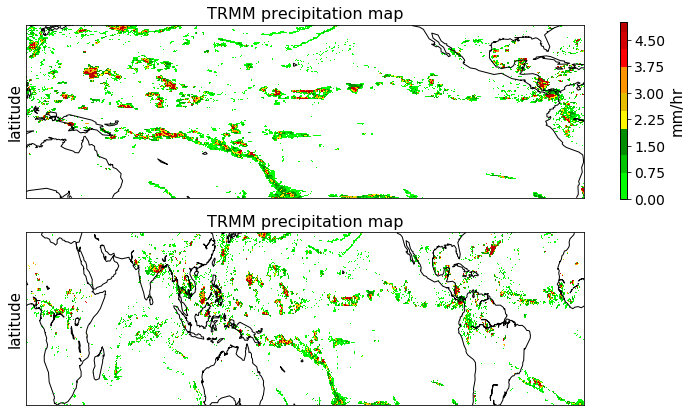

In [386]:
timestep=63

fig,axx=plt.subplots(2,1,figsize=(10,7))

ax=axx[0]
m = basemap.Basemap(projection='merc', llcrnrlon=lon[500], urcrnrlon=lon[-280], llcrnrlat=lat[0], urcrnrlat=lat[-1], resolution='c',ax=ax)
m.drawcoastlines()

CT=m.imshow(prc_masked[timestep,:,500:-280],cmap=precip_colormap,interpolation='none',norm=norm,aspect='auto',origin='lower')

ax.set_title('TRMM precipitation map', fontsize=16)

ax.tick_params(which='both',labelsize=16.0)
ax.set_ylabel('latitude',fontsize=15)

cbaxes = fig.add_axes([ .95,.535, 0.01, 0.35]) 
cbar=plt.colorbar(CT,cax=cbaxes,label='mm/hr',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)



prc_input=np.copy(prc_masked[timestep,:,:])
prc_input[prc_input<prc_min_thresh]=0.0
### Use pixel contiguity to identify clusters ##
labeled_prc, num_features = label(prc_input)
levels_labels=np.arange(0,num_features,1)
labels_masked=np.ma.masked_where(labeled_prc==0,labeled_prc)
pal=plt.get_cmap('tab20c')

ax=axx[1]
m = basemap.Basemap(projection='merc', llcrnrlon=lon[0], urcrnrlon=lon[-1], llcrnrlat=lat[0], urcrnrlat=lat[-1], resolution='c',ax=ax)
m.drawcoastlines()

CT=m.imshow(prc_masked[timestep,:,:],cmap=precip_colormap,interpolation='none',norm=norm,aspect='auto',origin='lower')

ax.set_title('TRMM precipitation map', fontsize=16)

ax.tick_params(which='both',labelsize=16.0)
ax.set_ylabel('latitude',fontsize=15)

cbaxes = fig.add_axes([ .95,.535, 0.01, 0.35]) 
cbar=plt.colorbar(CT,cax=cbaxes,label='mm/hr',orientation='vertical')
cbaxes.tick_params(which='both',labelsize=14.)
cbaxes.xaxis.set_major_formatter(FormatStrFormatter('%.1f'))
# cbar.set_ticks(levels_labels[::4])

font = matplotlib.font_manager.FontProperties(family='Arial',  size=15)
cbaxes.yaxis.label.set_font_properties(font)









In [387]:
time[timestep]

63.0

### 3. Create clusters and construct probability density functions (pdfs) for cluster size and cluster power. The data can be saved to file to avoid re-running time consuming computation. 

First declare some useful constants 

In [388]:
Rearth=6.37e6  ## Earth's equatorial radius in meters

## get the grid sizes dx and dy in meters ###

nx =lon[ind_lon].size # no. of grid points
ny =lat[ind_lat].size  

dx=2.*np.pi*Rearth*(np.cos(np.pi*lat[ind_lat]/180))/nx           #whole globe, periodic in x, dx in meters

dphi=np.gradient(lat[ind_lat])*np.pi/180  ## dphi in radians
dy=dphi*Rearth ## dy in meters


## for simplicity, we assume a single dx and dy for the domain. 
## Even though we should recognize that dx and dy vary with latitude.
precip_cluster_power_scale=2.5*dx.mean()*dy[0]*1e-6/3.6 ## cluster power in GW  ## Convert integrated precip. into power


Create bins to hold the cluster size and power pdfs

In [274]:
#### CLUSTER SIZE and POWER PDF bins ###

sizes=2**np.arange(0,18.25,.25)
sizes=np.unique(np.int_(sizes))-0.5

sz=(sizes[:-1]+sizes[1:])*0.5
sz_diff=np.diff(sizes)

pcp_clus_pow_bins=sizes*precip_cluster_power_scale*0.5
pcp_clust_sz=(pcp_clus_pow_bins[:-1]+pcp_clus_pow_bins[1:])*0.5
pcp_clust_sz_diff=np.diff(pcp_clus_pow_bins)



Create a list of precip. thresholds

In [272]:
pthresh_list=[.25, .5, .75, 1.0]  ## list of precip. thresholds

Function to perform cluster analysis. Takes file name as input and yields outputs:
    <ol>
    <li> Counts of precip. cluster power</li>
    <li> Counts of precip. cluster size </li>
    <li> List of cluster power </li>
    <li> List of cluster size </li>
    </ol>

The counts will be use to create historgrams. The lists of cluster power and size will allow us to estimate measures like the moment ratio (which is a proxy for the exponential cutoff).


In [391]:
def perform_cluster_analysis(file_name):
    
    print('working on %s:'%(file_name))
    
    hist_pcp_sizes={}   
    hist_pcp_clust_pow={}
    pcp_sizes={}
    pcp_power={}

    f=Dataset(file_name,'r')
    prc=f.variables['precip_trmm'][:] ## Read precip. (in mm/hr)
    f.close()
    
    for k in pthresh_list:
                
        arrp=np.copy(prc)
        arrp[prc>k]=1
        arrp[prc<=k]=0
        hist_pcp_sizes[k]=np.zeros_like(sz)    
        hist_pcp_clust_pow[k]=np.zeros_like(pcp_clust_sz)
        
        pcp_sizes[k]=np.zeros((1))
        pcp_power[k]=np.zeros((1))
        
        for ti in np.arange(prc.shape[0]):
            
            ### Cluster precipitation ###
        
            labeled_array_pcp, num_features_pcp = label(arrp[ti,:])
            ind=np.where(labeled_array_pcp[:,0]>0)[0]            
                
            ## Condition to take care of doubly periodic clusters ##

            # Assuming lat x lon array
            # Are there pixels along the longitude boundary whose label values are both > 0? 
            if any(np.logical_and(labeled_array_pcp[:,-1][ind]>0,labeled_array_pcp[:,0][ind]>0)):

                # If yes, then get their local addresses in the column        
                indy=np.where(np.logical_and(labeled_array_pcp[:,-1][ind]>0,labeled_array_pcp[:,0][ind]>0))
                # Loop through each address        
                for j in indy[0]:
                    # Get the destination label: of the last column
                    dest_label=labeled_array_pcp[:,-1][ind][j]
                    # Get the target label: of the first column
                    target_label=labeled_array_pcp[:,0][ind][j]
                    # Make all pixels with destination labels=target labels
                    labeled_array_pcp[labeled_array_pcp==dest_label]=target_label

                ## Update number of features
                num_features_pcp=np.unique(labeled_array_pcp[labeled_array_pcp>0]).size
                                        
            if num_features_pcp==0:
                mx,mn=1,0
            else:
                mx,mn=labeled_array_pcp.max(),1
                        
            ## Bin by cluster size ##

            hist_label=(ndimage.histogram(labeled_array_pcp,mn,mx,mx,labels=labeled_array_pcp))
            hist_pcp_sizes[k]+=np.histogram(hist_label,bins=sizes)[0]
            
            
###           snippet to determine timestep with largest clusters ###
#             if smax==0:
#                 smax=hist_label[hist_label>0].max()
#                 tmax=0
            
#             elif (hist_label[hist_label>0].max()>smax):
#                 smax=hist_label[hist_label>0].max()
#                 tmax=ti
            
            pcp_sizes[k]=np.append(pcp_sizes[k],hist_label[hist_label>0])
            label_objs=find_objects(labeled_array_pcp)
            pcp_cluster_pow=np.zeros(len(label_objs))
            pcp_cluster_sz=np.zeros(len(label_objs))
                        
            ## Compute and bin by cluster power
            ctr=0             
            for j in np.arange(len(label_objs)):

                sl=label_objs[j]
                arrp_slice=arrp[ti,:][sl]
                pcp_slice=prc[ti,:][sl]
                label_slice=labeled_array_pcp[sl]
                indj=np.where(label_slice==j+1)
                pcp_cluster_pow[j]=pcp_slice[indj].sum()*precip_cluster_power_scale
                pcp_cluster_sz[j]=pcp_slice[indj].size

            if (pcp_cluster_pow[pcp_cluster_pow>0].shape!=hist_label[hist_label>0].shape):
                print ('power, size:', pcp_cluster_pow[pcp_cluster_pow>0].shape,pcp_cluster_sz[pcp_cluster_sz>0].shape, 
                       hist_label[hist_label>0].shape)
                exit()

            pcp_power[k]=np.append(pcp_power[k],pcp_cluster_pow[pcp_cluster_pow>0])              
            hist_pcp_clust_pow[k]+=np.histogram(pcp_cluster_pow,bins=pcp_clus_pow_bins)[0]
            pcp_power[k]=pcp_power[k][1:]  ## neglect the first value, since it is zero
            pcp_sizes[k]=pcp_sizes[k][1:]
            
            
    return hist_pcp_clust_pow, hist_pcp_sizes, pcp_power, pcp_sizes 



We have a large number of files to work with. So to speed up the code, we will recruit multiple processors to work through the data. The jupyter machine has 160 processors, but we will recruit a fraction of this number to avoid clogging up the machine. To see how many processors are currently available, you can open a terminal and type `htop`.

<p>
We first define the number of desired processors that will work in parallel. Each processor will work with one TRMM file at a time the file name to the function `perform_cluster_analysis`. The results from different processors are then pooled at the end. <br> <b> Note:</b> this step can be time consuming depending on number of files being processed.
</p>

<a id='cell_multiprocess'></a>  

In [393]:
from multiprocessing import Pool  ### module for parallel programming
import time as time_module ## module to time this cell
start_time=time_module.time()
nproc=64  ### number of processors, optimized when less than equal the number of months
start_month=0 ### starting month
end_month=156 ### ending month
pool = Pool(processes=nproc)
pooled_list = pool.map(perform_cluster_analysis, list_trmm[start_month:end_month]) ### a list containing all the pooled results
print('Took %.2f minutes'%((time_module.time()-start_time)/60))

working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200201.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200204.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200205.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200202.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200203.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200207.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200206.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200210.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200209.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200301.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200208.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200304.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200212.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200305.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200306.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.200211.v7.nc:
working on /scratch/neel

working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201304.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201305.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201306.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201307.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201308.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201309.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201310.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201311.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201312.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201401.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201402.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201403.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201404.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201405.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201406.v7.nc:
working on /scratch/neelin/TRMM_3B42/TRMM.3B42.201407.v7.nc:
working on /scratch/neel

Organize the results from the cluster analysis, and save to file (optional).

In [267]:
ls

clusters_output_200801_200905.out           plots/
clusters_output_TRMM3B42_200201_201501.out  TRMM3B42_BL_map.pdf
clusters_pdfs_TRMM3B42_200201_201501.pdf    TRMM3B42_ERA-5_BL_map.pdf
clusters_pdfs_TRMM3B42_200801_200905.pdf    TRMM_cluster_analysis.ipynb*
files/                                      TRMM_clusters_MERRA.ipynb


<a id='cell_oragnize_data'></a>  

In [394]:
### create dictionaries to collect and store output ###
### each dictionary has a key associated with the precip. threshold ###
hist_pcp_sizes={}   
hist_pcp_clust_pow={}
pcp_sizes={}
pcp_power={}

## Create empty lists to store the cluster counts (hist) and the collection of actual cluster metrics
for k in pthresh_list:
    hist_pcp_sizes[k]=[]   
    hist_pcp_clust_pow[k]=[]  
    pcp_sizes[k]=[]  
    pcp_power[k]=[]  

### Stack the pooled output from above into these lists
for i in range(len(pooled_list)):
    cluster_list=(pooled_list[i])
    for k in pthresh_list:
        hist_pcp_clust_pow[k].append(cluster_list[0][k])
        hist_pcp_sizes[k].append(cluster_list[1][k])
        pcp_power[k].append(cluster_list[2][k])
        pcp_sizes[k].append(cluster_list[3][k])

### Convert the lists into arrays ###
for k in pthresh_list:
    hist_pcp_clust_pow[k]=np.asarray(hist_pcp_clust_pow[k]).sum(0)  ### sum the counts across all files
    hist_pcp_sizes[k]=np.asarray(hist_pcp_sizes[k]).sum(0)  ### sum the counts across all files
    pcp_power[k]=np.hstack(pcp_power[k]) ## stack all the power measurements
    pcp_sizes[k]=np.hstack(pcp_sizes[k]) ## stack all the size measurements

###
SAVE=True
if SAVE:
    dir_save='./' ### change as per required destination, default is current working directory
    data={}
    data['hist_pcp_sizes']=hist_pcp_sizes
    data['hist_pcp_clust_pow']=hist_pcp_clust_pow
    data['pcp_sizes']=pcp_sizes
    data['pcp_power']=pcp_power
    dt1=start_date+relativedelta(months=start_month)
    dt2=start_date+relativedelta(months=end_month)
    save_file_name=dir_save+"clusters_output_TRMM3B42_"+dt1.strftime("%Y%m")+"_"+dt2.strftime("%Y%m")+".out"
    with open(save_file_name, 'wb') as handle:
        pickle.dump(data, handle, protocol=pickle.HIGHEST_PROTOCOL)

    

 <b> Note: </b> if the file has been saved above, you do not have to re-run the cell [with multiprocessing](#cell_multiprocess) or the cell that [organizes the data](#cell_oragnize_data) when you restart the kernel.


Now open the saved file and create the cluster pdfs

In [270]:
### If reading an already saved file
READ=True
if READ:
#     read_file_name=dir_save+"clusters_output_TRMM3B42_"+dt1.strftime("%Y%m")+"_"+dt2.strftime("%Y%m")+".out" ## change as required
    read_file_name="./"+"clusters_output_TRMM3B42_200201_201501.out"
    with open(read_file_name, 'rb') as handle:
        f = pickle.load(handle,encoding='bytes')
    hist_pcp_clust_pow=f['hist_pcp_clust_pow']
    hist_pcp_sizes=f['hist_pcp_sizes']
    pcp_sizes=f['pcp_sizes']
    pcp_power=f['pcp_power']


### 4. Plot the pdfs for different time periods. You can play around to see how the pdfs vary with time length and period. Also include information about the cutoff in the plots. 

In the plot below, we will present the following information:
<ol>
    <li> The cluster size and power pdfs on a log-log plot for the different rain thresholds. </li>
    <li> A straight line fit over the power law range (set by user), and the slope for one rain threshold case </li>
    <li> The moment ratio (second moment over first moment) for cluster size ($a_M$) and power ($c_M$). These quantiies can thought of as <b> proxies for where the exponential cutoff occur</b>.
</ol>

/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:124: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:72: RuntimeWarning: divide by zero encountered in log10
/home/fiaz/anaconda3/env

NameError: name 'start_month' is not defined

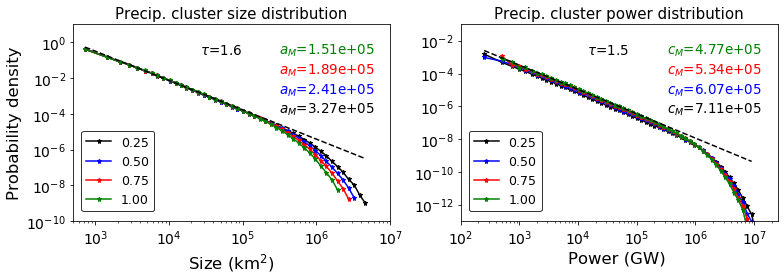

In [275]:
### Some user defined parameters ###
pixels_to_area=dx.mean()*dy[0]*1e-6 ### factor convert the number of pixels to area in km^2
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=3.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=2.8,5.2 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=16.5
ylabel_fontsize=16.5

## x and yaxis limits for cluster size
xlim_sz=[5e2,1e7] 
ylim_sz=[1e-10,1e1] ##

## x and yaxis limits for cluster power
xlim_pow=[1e2,2.5e7] ##
ylim_pow=[1e-13,1e-1] ##

## threshold legend font size
leg_fontsize=12.5

## moment ratio * power law slope font size
leg1_fontsize=13.5

## ticklabel font size
ticks_fontsize=14

### set the plot specs:
### size
fig=plt.figure(figsize=(11,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 2)
## assign separate name for each axis
ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 1])

### set four colors here for the different precip. thresholds ###
c=['black','blue','red','green']

### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[.55, 0.65, .75, .85,.65, 0.725, .8, .875 ]
posx=[.65, .65, .65, 0.65, .35, .4, .4 ]
iendt=[5, 4.5, 4, 3.5, 3.0, 3.0, 3.0, 3.0]

### Loop through each value of the precip. threshold and  plot the cluster pdfs ###
for j,k in enumerate(pthresh_list):
    ax=ax1

    ### there are the start and end of the power law range: adjust according to eye ###
    istrt,iend=istrt_sz,iend_sz

    
    if (k in pthresh_list):  ### use this if you want to plot a smaller subset of rain thresholds
        nid= ([l for l,m in enumerate(pthresh_list) if m==k])
        nid=np.int(nid[0])

        ### create pdfs out of cluster histogram of counts
        hist_pcp_clust_size_pdf=hist_pcp_sizes[k]/(sz_diff*hist_pcp_sizes[k].sum())
        
        ### remove bins with less than nthresh counts ##
        hist_pcp_clust_size_pdf[hist_pcp_sizes[k]<nthresh]=np.nan
                
        ### plot the cluster size pdf on a log-log scale ##
        ln1[nid],=ax.loglog(sz*pixels_to_area,hist_pcp_clust_size_pdf,marker='*',c=c[nid],markersize=5)

    ### The straight line fit to the power law range ###
    ### select portions of the curve bounded by the power law range ###
    arrx,arry=np.log10(sz*pixels_to_area),np.log10(hist_pcp_sizes[k]/(sz_diff*hist_pcp_sizes[k].sum()))
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<iend)],arry[np.logical_and(arrx>istrt,arrx<iend)]
    
    ### perform a linear regression over this selected portion ###
    ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
    
    ### Use the slope and intercept from the linear regression to create the straight line ###
    pdf_pcp_sizes=((sz*pixels_to_area)**(ret[0]))*(10**(ret[1]))
    
    ## Remove portions of the straight line that extend too far beyond the cutoff
    pdf_pcp_sizes[sz*pixels_to_area>5e6]=np.nan 
    
    ### Now compute the moment ratio and print it in on plot ##
    if (k in pthresh_list):
        sm=np.mean(pcp_sizes[k]**2)*pixels_to_area/np.mean(pcp_sizes[k])
        ax.text(posx[j],posy[j],'$a_M$=%.2e'%(sm),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])
#         ax.text(posx[j],posy[j],'$\\tau_{lin}$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=11.5,color=c[nid])
#         ax.loglog(sz*pixels_to_area,pdf_pcp_sizes*1e0,linestyle='--',c=c[nid])
        

    if (j==len(pthresh_list)-1):

        ### Set plot title and axis labels
        ax.set_title("Precip. cluster size distribution",fontsize=title_fontsize)
        ax.set_xlabel("Size ($\mathrm{km^2}$) ",fontsize=xlabel_fontsize)
        ax.set_ylabel("Probability density",fontsize=ylabel_fontsize)
        ax.set_xlim(xlim_sz)
        ax.set_ylim(ylim_sz)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e0, 1e-2, 1e-4, 1e-6, 1e-8, 1e-10]))
        ax.tick_params(which='both', labelsize=ticks_fontsize)
#         ax.text(0.001, 0.475,' Rain threshold\n (mm/hr)',transform=ax.transAxes,fontsize=leg_fontsize,fontweight='bold')
        ax.text(posx[j]-0.25,posy[j],'$\\tau$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=leg1_fontsize,color='black')
        ax.loglog(sz*pixels_to_area,pdf_pcp_sizes*1e0,linestyle='--',c='black')


        leg=ax.legend((ln1[0],ln1[1],ln1[2],ln1[3]), \
        ( "%.2f"%(pthresh_list[0]), "%.2f"%(pthresh_list[1]), "%.2f"%(pthresh_list[2]), "%.2f"%(pthresh_list[3]),
        ),fontsize=leg_fontsize, loc=(.025, .05),ncol=1 )
        ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')


    ax=ax2

    istrt,iend=istrt_pow,iend_pow 
    if (k in pthresh_list):
        hist_pcp_clust_pow_pdf=hist_pcp_clust_pow[k]/(pcp_clust_sz_diff*hist_pcp_clust_pow[k].sum())
        hist_pcp_clust_pow_pdf[hist_pcp_clust_pow_pdf==0]=np.nan
        ln2[nid],=ax.loglog(pcp_clust_sz,hist_pcp_clust_pow_pdf,marker='*',c=c[nid],markersize=5)


    arrx,arry=np.log10(pcp_clust_sz),np.log10(hist_pcp_clust_pow[k]/(pcp_clust_sz_diff*hist_pcp_clust_pow[k].sum()))
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<=iend)],arry[np.logical_and(arrx>istrt,arrx<=iend)]
    ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
    pdf_pcp_power=((pcp_clust_sz)**(ret[0]))*(10**(ret[1]))
    pdf_pcp_power[pcp_clust_sz>1e7]=np.nan


    if (k in pthresh_list):
#         ax.loglog(pcp_clust_sz,pdf_pcp_power*1e0,linestyle='--',c=c[nid])
        sm=np.mean(pcp_power[k]**2)/np.mean(pcp_power[k])
        ax.text(posx[j],posy[j],'$c_M$=%.2e'%(sm),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])

    #         ax.text(posx[j],posy[j],'$\\tau_{lin}$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=11.5,color=c[nid])
#         ax.text(posx[j],posy[j],'$\\tau_{lin}$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=11.5,color=c[nid])
        ax.tick_params(which='both', labelsize=ticks_fontsize)

    if (j==len(pthresh_list)-1):

#         ax.text(0.001, 0.5,' Rain threshold\n (mm/hr)',transform=ax.transAxes,fontsize=9,fontweight='bold')
        leg=ax.legend((ln1[0],ln1[1],ln1[2],ln1[3]), \
        ( "%.2f"%(pthresh_list[0]), "%.2f"%(pthresh_list[1]), "%.2f"%(pthresh_list[2]), "%.2f"%(pthresh_list[3]),
        ),fontsize=leg_fontsize, loc=(.025, .05),ncol=1 )
        ## make legend box color black ##
        frame=leg.get_frame()
        frame.set_edgecolor('black')
        ax.loglog(pcp_clust_sz,pdf_pcp_power*1e0,linestyle='--',c='black')
    
        ax.text(posx[j]-0.25,posy[j],'$\\tau$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=leg1_fontsize,color='black')
        ax.set_title("Precip. cluster power distribution",fontsize=title_fontsize)
        ax.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax.set_xlim(xlim_pow)
        ax.set_ylim(ylim_pow)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))

plt.tight_layout()
plt.subplots_adjust(top=0.9)



SAVE_FIG=True
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    dt1=start_date+relativedelta(months=start_month)
    dt2=start_date+relativedelta(months=end_month)
    save_fig_name=dirp+"clusters_pdfs_TRMM3B42_"+dt1.strftime("%Y%m")+"_"+dt2.strftime("%Y%m")+".pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')




In [463]:
levels_pow=np.array((2.0,4.0,5.5,6.0,6.25,6.5))



/home/fiaz/anaconda3/envs/aos112/lib/python3.7/site-packages/ipykernel_launcher.py:77: RuntimeWarning: divide by zero encountered in log10


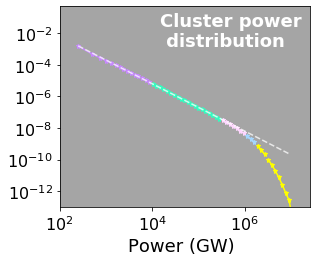

In [471]:
### Some user defined parameters ###
pixels_to_area=dx.mean()*dy[0]*1e-6 ### factor convert the number of pixels to area in km^2
nthresh=25 #Discard bins with fewer than nthresh samples
istrt_sz,iend_sz=3.0,5.0 ## the power law range for size (10^3 to 10^5)
istrt_pow,iend_pow=2.8,5.2 ### set a ballpark range for the power law, so the straight line fit is over that range

title_fontsize=15
xlabel_fontsize=18
ylabel_fontsize=18

## x and yaxis limits for cluster size
xlim_sz=[5e2,1e7] 
ylim_sz=[1e-10,1e1] ##

## x and yaxis limits for cluster power
xlim_pow=[1e2,2.5e7] ##
ylim_pow=[1e-13,5e-1] ##

## threshold legend font size
leg_fontsize=13.5

## moment ratio * power law slope font size
leg1_fontsize=18

## ticklabel font size
ticks_fontsize=16

### set the plot specs:
### size
fig=plt.figure(figsize=(4.5,4.))
## grid: 1 row , 2 colum plot
gs = gridspec.GridSpec(1, 1)
## assign separate name for each axis
# ax1 = plt.subplot(gs[0, 0])
ax2 = plt.subplot(gs[0, 0])

### set four colors here for the different precip. thresholds ###
c=['black','blue','red','green']

### create empty dictionaries to hold the legends 
ln1={}
ln2={}

### positions for some of the text on the plot
posy=[.55, 0.65, .75, .85,.65, 0.725, .8, .875 ]
posx=[.65, .65, .65, 0.65, .35, .4, .4 ]
iendt=[5, 4.5, 4, 3.5, 3.0, 3.0, 3.0, 3.0]

### Loop through each value of the precip. threshold and  plot the cluster pdfs ###
for j,k in enumerate(pthresh_list[:1]):


    ax=ax2

    istrt,iend=istrt_pow,iend_pow 
    if (k in pthresh_list):
        hist_pcp_clust_pow_pdf=hist_pcp_clust_pow[k]/(pcp_clust_sz_diff*hist_pcp_clust_pow[k].sum())
        hist_pcp_clust_pow_pdf[hist_pcp_clust_pow_pdf==0]=np.nan
        
        for m in range(len(levels_pow)):
            if m<len(levels_pow)-1:
                color_ind=m
                ind=np.where(np.logical_and(pcp_clust_sz>=10**levels_pow[m],pcp_clust_sz<10**levels_pow[m+1]))
            elif m==len(levels_pow)-1:
                ind=np.where(pcp_clust_sz>=10**levels_pow[m])
                color_ind=m-1

            x=pcp_clust_sz[ind]
            y=hist_pcp_clust_pow_pdf[ind]
#                 ln2[nid],=ax.loglog(pcp_clust_sz,hist_pcp_clust_pow_pdf,marker='*',c=discrete_colors[0],
#                                      markersize=5)
            ln2[nid],=ax.loglog(x,y,marker='*',c=discrete_colors[color_ind],
                                 markersize=5)



    arrx,arry=np.log10(pcp_clust_sz),np.log10(hist_pcp_clust_pow[k]/(pcp_clust_sz_diff*hist_pcp_clust_pow[k].sum()))
    arrx_fin,arry_fin=arrx[np.logical_and(arrx>istrt,arrx<=iend)],arry[np.logical_and(arrx>istrt,arrx<=iend)]
    ret=linregress(arrx_fin[np.isfinite(arry_fin)],arry_fin[np.isfinite(arry_fin)])
    pdf_pcp_power=((pcp_clust_sz)**(ret[0]))*(10**(ret[1]))
    pdf_pcp_power[pcp_clust_sz>1e7]=np.nan


    if (k in pthresh_list):
#         ax.loglog(pcp_clust_sz,pdf_pcp_power*1e0,linestyle='--',c=c[nid])
        sm=np.mean(pcp_power[k]**2)/np.mean(pcp_power[k])
#         ax.text(posx[j],posy[j],'$c_M$=%.2e'%(sm),transform=ax.transAxes,fontsize=leg1_fontsize,color=c[nid])

    #         ax.text(posx[j],posy[j],'$\\tau_{lin}$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=11.5,color=c[nid])
#         ax.text(posx[j],posy[j],'$\\tau_{lin}$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=11.5,color=c[nid])
        ax.tick_params(which='both', labelsize=ticks_fontsize)

    if (j==len(pthresh_list)-4):

#         ax.text(0.001, 0.5,' Rain threshold\n (mm/hr)',transform=ax.transAxes,fontsize=9,fontweight='bold')
        ax.loglog(pcp_clust_sz,pdf_pcp_power*1e0,linestyle='--',c='white',alpha=0.75)
    
#         ax.text(posx[j]-0.25,posy[j]+0.25,'$\\tau$=%.1f'%(-ret[0]),transform=ax.transAxes,fontsize=leg1_fontsize,color='black')
#         ax.set_title("Precip. cluster power distribution",fontsize=title_fontsize)
        ax.set_xlabel("Power (GW) ",fontsize=xlabel_fontsize)
        ax.set_xlim(xlim_pow)
        ax.set_ylim(ylim_pow)
        ax.yaxis.set_major_locator(plt.FixedLocator([1e-2, 1e-4, 1e-6, 1e-8, 1e-10,1e-12]))
        ax.text(posx[j]-0.25,posy[j]+0.25,"Cluster power\n distribution",
                transform=ax.transAxes,fontsize=leg1_fontsize,color='white',fontweight='bold')

# ax.set_facecolor('gray',alpha=0.5)
ax.patch.set_facecolor('black')
ax.patch.set_alpha(0.35)


plt.tight_layout()
plt.subplots_adjust(top=0.9)



SAVE_FIG=True
if SAVE_FIG:
    dirp='./' ## current location, but change as needed
    save_fig_name=dirp+"clusters_power_pdf_TRMM3B42_2002_2015"+".pdf"
    plt.savefig(save_fig_name,format='pdf',dpi=150,bbox_inches='tight')





You can compare the cutoffs (moment ratios) and the power law slope across different time periods. You could even compute the moment ratios for each year, and plot the time series

Also try plotting a log-linear plot for the cluster extremes

In [314]:
list1=[[np.zeros(4),np.zeros(4)],[np.zeros(4)]]
list1_flat=[k for i in list1 for k in i]
len(list1_flat)

3